# Anthropic Claude 3 API 사용하기
---

## Import Package

In [1]:
import anthropic
import os
import httpx
import base64
import imghdr
import io
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from pathlib import Path

## Set Variable

In [2]:
api_key = os.environ.get("ANTHROPIC_API_KEY")

In [3]:
client = anthropic.Anthropic(api_key=api_key)

## Function

In [4]:
def get_response_from_claude(question):
    result_text = ""
    
    response = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=1000,
        temperature=0.0,
        system="Respond only in Yoda-speak.",
        messages=[{"role": "user", "content": question}]
    )
    
     # 응답 객체에서 텍스트 내용만 추출
    if not response.content or not isinstance(response.content, list):
        result_text = "No response or unexpected response format."
    else:
        response_texts = [block.text for block in response.content if hasattr(block, 'text')]
        result_text = " ".join(response_texts)

    return result_text

## Text generation

In [21]:
# 함수 사용 예
question = "Recommend a programming language."
response = get_response_from_claude(question)
print(response)

Recommend a programming language, I will. Python, a wise choice it is. Versatile and powerful, it is. Easy to learn, it is, yet capable of great things, it remains. A large community and many libraries, it has. For beginners and experts alike, suitable it is. Python, you should consider. Mmm, yes.


## Vision Function

In [5]:
def load_and_encode_images(paths):
    encoded_images = []
    for path in paths:
        media_type = None  # 초기값은 None으로 설정

        # URL인 경우
        if path.startswith('http'):
            response = httpx.get(path)
            image_data = response.content
            
            # URL에서 파일 확장자 추출
            file_extension = Path(path).suffix.lower()
            if file_extension in ['.jpg', '.jpeg']:
                media_type = "image/jpeg"
            elif file_extension in ['.png']:
                media_type = "image/png"
            else:
                print(f"Unsupported media type for URL: {path}")
                continue  # 지원하지 않는 파일 형식인 경우, 건너뛰기
            
            response.close()
        
        # 로컬 파일 경로인 경우
        else:
            with open(path, "rb") as image_file:
                image_data = image_file.read()
                img_type = imghdr.what(None, h=image_data)
                
                if img_type == "jpeg":
                    media_type = "image/jpeg"
                elif img_type == "png":
                    media_type = "image/png"
                else:
                    print(f"Unsupported file format: {path}")
                    continue  # 지원하지 않는 파일 형식인 경우, 건너뛰기
        
        if media_type:
            # Base64 인코딩 후 저장
            encoded_image = base64.b64encode(image_data).decode("utf-8")
            encoded_images.append({
                "type": "image",
                "media_type": media_type,
                "data": encoded_image,
            })

    return encoded_images


def create_prompt_with_images(encoded_images, text):
    content = []
    for image in encoded_images:
        # 이미지 객체 구조를 API 요구사항에 맞게 조정
        content.append({
            "type": "image",
            "source": {
                "type": "base64",  # 'type' 키를 'base64'로 명시
                "media_type": image["media_type"],  # 이미지의 미디어 타입
                "data": image["data"],  # Base64 인코딩된 이미지 데이터
            },
        })
    content.append({
        "type": "text",
        "text": text,  # 질문 또는 설명 텍스트
    })
    
    prompts = [{
        "role": "user",
        "content": content,
    }]
    return prompts



def display_response(images, text):
    for image in images:
        img_data = base64.b64decode(image["data"])
        img = PILImage.open(io.BytesIO(img_data))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    print("Response:", text)

# 예시 사용
def chat_with_images_and_text(image_urls, text_question):
    # 이미지 인코딩
    encoded_images = load_and_encode_images(image_urls)

    # 질문 생성
    prompts = create_prompt_with_images(encoded_images, text_question)

    # Anthropics API를 통해 답변 받기 (가상의 함수, 실제 API 호출 구현 필요)
    response = client.messages.create(model="claude-3-opus-20240229", max_tokens=1024, messages=prompts)
    
    # 응답에서 텍스트 내용만 추출
    result_text = ""
    
    for content_block in response.content:
        if content_block.type == "text":
            result_text += content_block.text + "\n"

    # 답변 표시
    display_response(encoded_images, result_text)
    
    return response

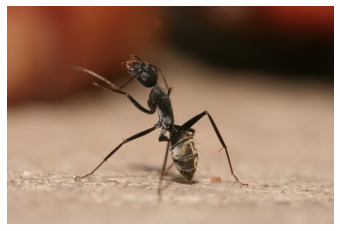

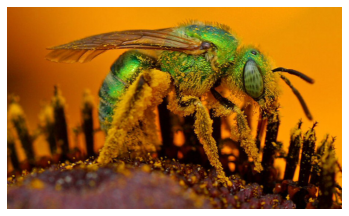

Response: The first image shows an extreme close-up of an ant against a plain brown background. The ant appears to be standing on its hind legs with its front legs raised, likely in a defensive or aggressive posture. The details of the ant's exoskeleton, including its segmented body, antennae, and mandibles, are clearly visible due to the high magnification and sharp focus of the photograph.

The second image depicts a green metallic sweat bee covered in tiny water droplets, likely from morning dew or rain. The bee's iridescent exoskeleton shimmers with hues of green, blue and gold against the orange background, creating a striking color contrast. The water droplets on its fuzzy body and wings add an interesting texture and catch the light, further enhancing the visual appeal of the photograph. The image showcases the intricate beauty and detail of this small insect.



In [6]:
# 이미지 URL 리스트
image_paths = [
    "https://upload.wikimedia.org/wikipedia/commons/a/a7/Camponotus_flavomarginatus_ant.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/b/b5/Iridescent.green.sweat.bee1.jpg"
]

# 질문
text_question = "Describe these images."

# 함수 실행
response = chat_with_images_and_text(image_paths, text_question)

### Classification

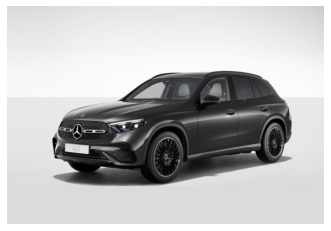

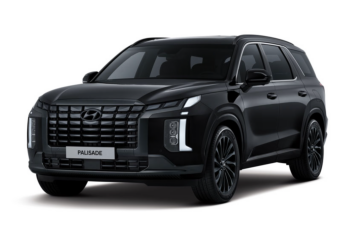

Response: 첫번째 이미지는 Mercedes-Benz GLC 클래스 SUV 모델이고, 두번째 이미지는 Hyundai Palisade SUV 모델입니다.

두 차량 모두 고급스러운 외관 디자인을 가지고 있으며, 가족용 대형 SUV 차량의 특징을 잘 보여주고 있습니다. Mercedes-Benz GLC는 프리미엄 브랜드의 고급스러움을 강조한 반면, Hyundai Palisade는 보다 대중적인 디자인을 추구한 것으로 보입니다.



In [61]:
image_paths = ["asset/images/test_8.png", "asset/images/test_9.png"]
text_question = "주어진 두 이미지를 분석하여 각각 차량의 모델을 반환합니다."
response = chat_with_images_and_text(image_paths, text_question)

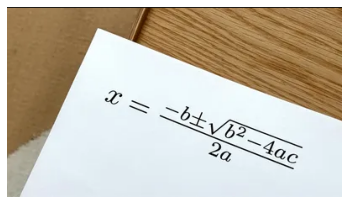

Response: 이 방정식은 2차 방정식의 일반적인 형태입니다. 2차 방정식은 ax^2 + bx + c = 0의 형태로 표현되며, 여기서 a, b, c는 실수이고 a는 0이 아닙니다.

2차 방정식을 풀기 위해서는 다음과 같은 방법을 사용할 수 있습니다:

1. 인수분해 (factoring): 방정식을 인수분해하여 (ax + m)(bx + n) = 0의 형태로 만들고, 각 인수를 0으로 만드는 x값을 찾습니다. 

2. 근의 공식 (quadratic formula): 근의 공식 x = (-b ± √(b^2 - 4ac)) / 2a 를 사용하여 x의 값을 직접 계산합니다.

3. 완전제곱 (completing the square): x^2 + (b/a)x 형태가 되도록 방정식을 변형한 후, 제곱식을 완성하여 x에 대해 풉니다.

2차 방정식은 그래프로 나타내면 포물선 모양이 됩니다. 이 포물선이 x축과 만나는 점의 x좌표가 바로 2차 방정식의 해, 즉 근이 됩니다. 근의 개수는 판별식 b^2 - 4ac의 값에 따라 달라집니다.

2차 방정식은 물리학, 공학, 경제학 등 다양한 분야에서 활용되며, 최적화 문제나 운동 방정식 등을 해결하는 데 사용됩니다.



In [81]:
image_paths = ["asset/images/test_3.png"]
text_question = "이 방정식은 무엇을 위한 것인가요? 사용방법을 설명해주세요"
response = chat_with_images_and_text(image_paths, text_question)

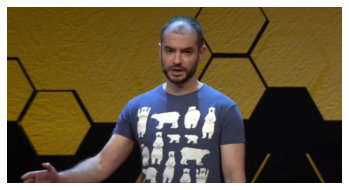

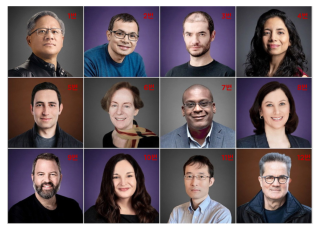

Response: The man in the first image is wearing a shirt with bears on it, which matches portrait number 2 in the second image grid.



In [74]:
image_paths = ["asset/images/test_4.png", "asset/images/test_5.png"]
text_question = "첫 번째 이미지의 사람이 두 번째 이미지에 몇 번에 해당하는지 찾아서 번호만 알려주세요."
response = chat_with_images_and_text(image_paths, text_question)

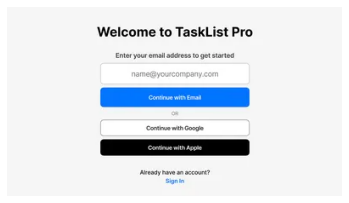

Response: 아래는 제공된 디자인을 기반으로 Tailwind CSS를 사용하여 React 컴포넌트로 구현한 예시 코드입니다:

```jsx
import React from 'react';

const WelcomeForm = () => {
  return (
    <div className="flex flex-col items-center justify-center min-h-screen bg-gray-100">
      <div className="bg-white p-8 rounded-lg shadow-md w-full max-w-md">
        <h2 className="text-2xl font-semibold mb-6">Welcome to TaskList Pro</h2>
        <p className="text-gray-600 mb-8">Enter your email address to get started</p>
        
        <div className="mb-4">
          <button className="w-full bg-blue-500 text-white py-2 px-4 rounded-md hover:bg-blue-600 transition duration-200">
            Continue with Email
          </button>
        </div>
        
        <div>
          <button className="w-full bg-white text-gray-800 border border-gray-300 py-2 px-4 rounded-md hover:bg-gray-100 transition duration-200">
            Continue with Google
          </button>
        </div>
        
        <div className="text-center mt-6">
 

In [83]:
image_paths = ["asset/images/test_6.png"]
text_question = "이 디자인을 Tailwind CSS를 사용하여 React 컴포넌트로 변환하세요"
response = chat_with_images_and_text(image_paths, text_question)

### OCR

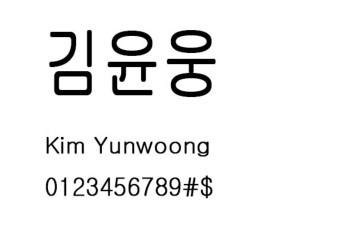

Response: 사진에서 추출한 텍스트는 다음과 같습니다:

김윤웅
Kim Yunwoong 
0123456789#$

위 텍스트를 보면 김윤웅이라는 이름과 Kim Yunwoong이라는 영문 이름, 그리고 숫자와 기호로 구성된 '0123456789#$' 문자열을 확인할 수 있습니다.



In [64]:
image_paths = ["asset/images/test_7.jpg"]
text_question = "이 사진에서 텍스트 추출해서 OCR 수행해줘"
response = chat_with_images_and_text(image_paths, text_question)

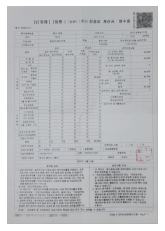

Response: 이 진료비 상세내역서에 따르면, 환자부담금액은 45,000원입니다. 상세 내역 중 "계" 행을 보면 환자부담금으로 45,000원이 기재되어 있습니다.



In [68]:
image_paths = ["asset/images/test_8.png"]
text_question = "환자부담금액을 알려줘"
response = chat_with_images_and_text(image_paths, text_question)

### Image text to JSON
Extract this recipe to a JSON file.

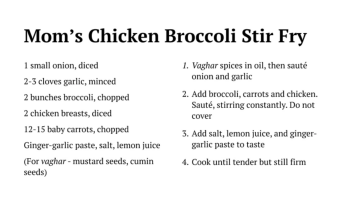

Response: {
  "name": "Mom's Chicken Broccoli Stir Fry",
  "ingredients": [
    {
      "item": "small onion",
      "amount": 1,
      "unit": null,
      "preparation": "diced"
    },
    {
      "item": "garlic",
      "amount": 2,
      "unit": "cloves",
      "preparation": "minced"     
    },
    {
      "item": "broccoli",
      "amount": 2,
      "unit": "bunches",
      "preparation": "chopped"
    },
    {
      "item": "chicken breasts",
      "amount": 2,
      "unit": null,
      "preparation": "diced"
    },
    {
      "item": "baby carrots",
      "amount": 12,
      "unit": null,
      "preparation": "chopped"
    },
    {
      "item": "ginger-garlic paste",
      "amount": null,
      "unit": null,
      "preparation": null
    },
    {
      "item": "salt",
      "amount": null,
      "unit": null,
      "preparation": null  
    },
    {
      "item": "lemon juice",
      "amount": null,
      "unit": null,
      "preparation": null
    }
  ],
  "instructions": [


In [82]:
image_paths = ["asset/images/test_9.png"]
text_question = "이 레시피를 JSON 파일로 추출합니다"
response = chat_with_images_and_text(image_paths, text_question)

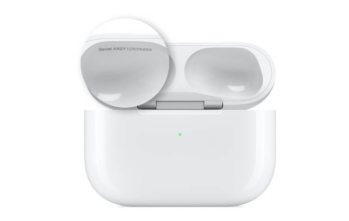

Response: The serial number (S/No) shown on the Apple AirPods case in the image is X0VY12C3X4B0x.



In [80]:
image_paths = ["asset/images/test_10.png"]
text_question = "S/No를 알려줘"
response = chat_with_images_and_text(image_paths, text_question)

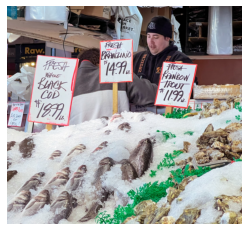

Response: {
  "items": [
    {
      "name": "Whole Black Cod",
      "price": 15.99
    },
    {
      "name": "Bronzino",
      "price": 14.99
    },
    {
      "name": "Rainbow Trout",
      "price": 11.99
    }
  ]
}

The image shows a display of fresh fish at a fish market. There are handwritten signs in front of the fish indicating the name and price per pound for three types of fish:
1. Fresh Whole Black Cod at $15.99/lb
2. Fresh Bronzino at $14.99/lb 
3. Fresh Rainbow Trout at $11.99/lb
The fish are arranged on a bed of ice, with some greenery added as garnish. A worker at the fish market can be seen in the background.



In [75]:
image_paths = ["asset/images/test_11.png"]
text_question = "Extract the items and prices from a fish market photo and output them in JSON."
response = chat_with_images_and_text(image_paths, text_question)

### 이미지 추론

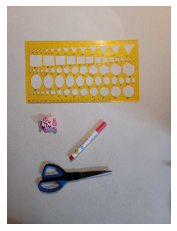

Response: 이미지에서 자와 비교해 보면, 자의 길이가 약 20cm로 보이고 있습니다. 이를 바탕으로 추론해보면 작은 헬로우 키티 그림 장난감의 크기는 대략 1-2cm 정도로 추정됩니다.



In [84]:
image_paths = ["asset/images/test_11.jpg"]  # N개의 이미지 경로
text_question = "이미지에서 자를 기반으로 장난감의 크기를 추론하여 Cm로 알려줘"
response = chat_with_images_and_text(image_paths, text_question)

### Face Recognition